# A guide to fine-tuning Code Llama

**In this guide I show you how to fine-tune Code Llama to become a beast of an GAML developer. For coding tasks, you can generally get much better performance out of Code Llama than Llama 2, especially when you specialise the model on a particular task:**

- I use the [b-mc2/sql-create-context](https://huggingface.co/datasets/b-mc2/sql-create-context) which is a bunch of text queries and their corresponding SQL queries
- A Lora approach, quantizing the base model to int 8, freezing its weights and only training an adapter
- Much of the code is borrowed from [alpaca-lora](https://github.com/tloen/alpaca-lora), but I refactored it quite a bit for this


### 2. Pip installs


In [1]:
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install bitsandbytes
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U datasets scipy ipywidgets
#import locale # colab workaround
#locale.getpreferredencoding = lambda: "UTF-8" # colab workaround
!pip install wandb
!pip install huggingface_hub

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 9.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

### Loading dataset


### Load dataset


In [4]:
from google.colab import files
uploaded = files.upload()

Saving eval.json to eval.json


In [5]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='train-complex99.json', split='train')
print(train_dataset)
eval_dataset = load_dataset('json', data_files='eval.json', split='train')
print(eval_dataset)

Dataset({
    features: ['question', 'answer'],
    num_rows: 98
})


Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['question', 'answer'],
    num_rows: 9
})


In [6]:
def formatting_func(input):
  text = f"### Question: {input['question']}\n ### Answer: {input['answer']}"
  return text

In [7]:
print(train_dataset[3])

{'question': 'How can you declare and initialize the variable "nb_preys_init" to the value 200 in the global section of a GAML model?', 'answer': 'global {\n        int nb_preys_init <- 200;\n        init {\n                create prey number: nb_preys_init;\n        }\n}'}


Each entry is made up of a text 'question',

*   List item
*   List item
 and the 'answer'.

### Load model
I load code llama from huggingface in int8. Standard for Lora:

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "codellama/CodeLlama-7b-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/637 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [21]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [22]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

107


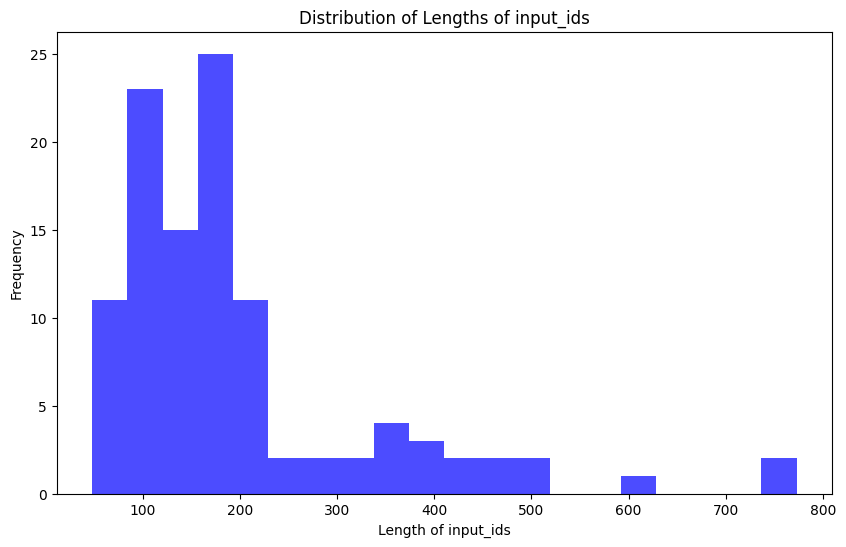

In [23]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

torch_dtype=torch.float16 means computations are performed using a float16 representation, even though the values themselves are 8 bit ints.

If you get error "ValueError: Tokenizer class CodeLlamaTokenizer does not exist or is not currently imported." Make sure you have transformers version is 4.33.0.dev0 and accelerate is >=0.20.3.


### 3. Check base model
A very good common practice is to check whether a model can already do the task at hand. Fine-tuning is something you want to try to avoid at all cost:


In [10]:
eval_prompt = """You are a text-to-GAML model. Your job is to answer questions about a database. You are given a question and context regarding one or more tables.

You must output the GAML query that answers the question.
### Input:
Generate for me a model simulate the air pollution

### Response:
"""
# {'question': 'Name the comptroller for office of prohibition', 'context': 'CREATE TABLE table_22607062_1 (comptroller VARCHAR, ticket___office VARCHAR)', 'answer': 'SELECT comptroller FROM table_22607062_1 WHERE ticket___office = "Prohibition"'}
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=100)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


You are a text-to-GAML model. Your job is to answer questions about a database. You are given a question and context regarding one or more tables.

You must output the GAML query that answers the question.
### Input:
Generate for me a model simulate the air pollution

### Response:

    }

    public function getName()
    {
        return 'sylius_product_variant_show';
    }
} namespace Sylius\Bundle\CoreBundle\Form\Type;

use Symfony\Component\Form\AbstractType;
use Symfony\Component\Form\FormBuilderInterface;
use Symfony\Component\OptionsResolver\OptionsResolverInterface;

/**
 * @author Paweł


### 4. Tokenization
Setup some tokenization settings like left padding because it makes [training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa):

Setup the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning](https://neptune.ai/blog/self-supervised-learning) is:

In [24]:
def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=512, # optional base on dataset
        padding=False,
        return_tensors=None,
    )

    # "self-supervised learning" means the labels are also the inputs:
    result["labels"] = result["input_ids"].copy()

    return result

In [25]:
def formatting_func(input):
  text = f"### Question: {input['question']}\n ### Answer: {input['answer']}"
  return text

And run convert each data_point into a prompt that I found online that works quite well:

In [26]:
max_length = 795 # This was an appropriate max length for my dataset and I eyeballed it

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

Reformat to prompt and tokenize each sample:

In [27]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

In [28]:
print(tokenized_train_dataset[1]['input_ids'])

[1, 835, 894, 29901, 1128, 508, 306, 4529, 278, 6606, 8393, 29892, 8820, 29892, 322, 4010, 18930, 297, 263, 1904, 297, 330, 8807, 29973, 13, 835, 673, 29901, 6606, 426, 13, 1678, 849, 22402, 6606, 8393, 1244, 13, 268, 13, 1678, 849, 22402, 6606, 8820, 1244, 13, 268, 13, 1678, 849, 22402, 6606, 4010, 18930, 1244, 13, 29913, 2]


107


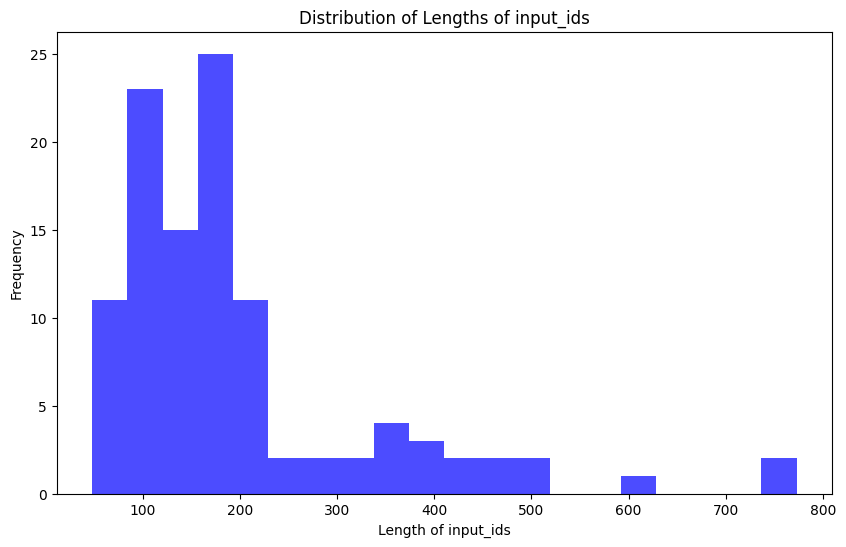

In [29]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [15]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )


### 5. Setup Lora

In [16]:
from peft import LoraConfig, get_peft_model
model.train() # put model back into training model

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)
print_trainable_parameters(model)

# trainable params: 40554752 || all params: 3541098752 || trainable%: 1.1452589955898524

trainable params: 40554752 || all params: 3541098752 || trainable%: 1.1452589955898524


To resume from a checkpoint, set resume_from_checkpoint to the path of the adapter_model.bin you want to resume from. This code'll replace the lora adapter attached to the model:

In [16]:
import os
from peft import set_peft_model_state_dict
resume_from_checkpoint = "" # set this to the adapter_model.bin file you want to resume from

if resume_from_checkpoint:
    if os.path.exists(resume_from_checkpoint):
        print(f"Restarting from {resume_from_checkpoint}")
        adapters_weights = torch.load(resume_from_checkpoint)
        set_peft_model_state_dict(model, adapters_weights)
    else:
        print(f"Checkpoint {resume_from_checkpoint} not found")

In [17]:
import wandb, os
wandb.login()

wandb: Currently logged in as: phuonganhnn25-3 (7bmistral). Use `wandb login --relogin` to force relogin


True

Optional stuff to setup Weights and Biases to view training graphs:

In [18]:
wandb_project = "llama-code-gama"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

In [19]:
if torch.cuda.device_count() > 1:
    # keeps Trainer from trying its own DataParallelism when more than 1 gpu is available
    model.is_parallelizable = True
    model.model_parallel = True

### 6. Training arguments
If you run out of GPU memory, change per_device_train_batch_size. The gradient_accumulation_steps variable should ensure this doesn't affect batch dynamics during the training run. All the other variables are standard stuff that I wouldn't recommend messing with:

In [24]:
import transformers
from datetime import datetime

base_model_name = "llamacode"
run_name = base_model_name
output_dir = "./" + run_name
output_dir = "gaml-code-llama"

training_args = transformers.TrainingArguments(

        per_device_train_batch_size=2,
        gradient_accumulation_steps=2,
        warmup_steps=1,
        max_steps=150,
        learning_rate=3e-4,
        fp16=True,
        logging_steps=10,
        optim="adamw_torch",
        evaluation_strategy="steps", # if val_set_size > 0 else "no",
        save_strategy="steps",
        eval_steps=20,
        save_steps=20,
        output_dir=output_dir,
        # save_total_limit=3,
        load_best_model_at_end=False,
        # ddp_find_unused_parameters=False if ddp else None,
        group_by_length=True, # group sequences of roughly the same length together to speed up training
        report_to="wandb", # if use_wandb else "none",
        run_name=f"codellama-{datetime.now().strftime('%Y-%m-%d-%H-%M')}", # if use_wandb else None,
    )

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=training_args,
    data_collator=transformers.DataCollatorForSeq2Seq(tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True),
)

model.config.use_cache = False

In [26]:
import torch

torch.cuda.empty_cache()
trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 37.06 MiB is free. Process 42848 has 14.71 GiB memory in use. Of the allocated memory 14.18 GiB is allocated by PyTorch, and 416.91 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Load the final checkpoint
Now for the moment of truth! Has our work paid off...?

In [ ]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer

base_model = "codellama/CodeLlama-7b-hf"
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained("codellama/CodeLlama-7b-hf")

To load a fine-tuned Lora/Qlora adapter use PeftModel.from_pretrained. ```output_dir``` should be something containing an adapter_config.json and adapter_model.bin:

In [ ]:
from peft import PeftModel
model = PeftModel.from_pretrained(model, output_dir)

Try the same prompt as before:

In [ ]:
eval_prompt = """You are a powerful text-to-SQL model. Your job is to answer questions about a database. You are given a question and context regarding one or more tables.

You must output the SQL query that answers the question.
### Input:
Which Class has a Frequency MHz larger than 91.5, and a City of license of hyannis, nebraska?

### Context:
CREATE TABLE table_name_12 (class VARCHAR, frequency_mhz VARCHAR, city_of_license VARCHAR)

### Response:
"""

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=100)[0], skip_special_tokens=True))


And the model outputs:
```
SELECT class FROM table_name_12 WHERE frequency_mhz > 91.5 AND city_of_license = "hyannis, nebraska"
```
So it works! If you want to convert your this adapter to a Llama.cpp model to run locally follow my other [guide](https://ragntune.com/blog/A-guide-to-running-Llama-2-qlora-loras-on-Llama.cpp). If you have any questions, shoot me a message on [Elon Musk's website](https://twitter.com/samlhuillier_).
